In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

# 0. Functions

In [2]:
def like_calc(y_sim, y_mes, std):
    like = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return like

def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [3]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'5% Median: {med1} \n Stats: {stat1} \n')
    print(f'10% Median: {med2} \n Stats: {stat2} \n')
    print(f'15% Median: {med3} \n Stats: {stat3} \n')
    print(f'20% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    means = [stat1.mean, stat2.mean, stat3.mean, stat4.mean]
    return meds, maxs, means

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'BWR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [4]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Likelihood', fontsize=14, labelpad=15)
        #ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [5]:
pklfile = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [6]:
ratios = XY.loc[:, lbls].copy()

In [7]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)

## (a) Get test sample for LL calcs

In [9]:
# Choosing PWR sample intentionally
sim_idx = 5010
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
5010,pwr,306.249839,3.22,39382.5,w17x17


In [11]:
ratios.drop(5010, inplace=True)

## (b) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [12]:
fullXY = ratios.loc[ratios['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [14]:
uncs = [0.05, 0.10, 0.15, 0.20] 
for unc in uncs:
    like_name = 'Likelihood' + str(unc)
    fullXY[like_name] = X.apply(lambda row: like_calc(row, test_sample.iloc[0], unc*row), axis=1)
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    fullXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [15]:
fullXY.to_csv('likelihood_idx5010_10ratios_opusupdate-aug2019.csv')
fullXY.head()

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
1,pwr,0.000839,0.53,2006.54,ce14x14,1.093932,0.004286,0.211022,0.000971,10.680506,...,4.495815e+08,0.0,-1.124658e+09,2.247908e+08,0.0,-4.998482e+08,1.498605e+08,0.0,-2.811646e+08,1.123954e+08
2,pwr,0.592485,0.53,2006.54,ce14x14,1.080899,0.004286,0.214933,0.000982,9.547601,...,4.601193e+08,0.0,-1.151023e+09,2.300597e+08,0.0,-5.115657e+08,1.533731e+08,0.0,-2.877557e+08,1.150298e+08
3,pwr,1.109213,0.53,2006.54,ce14x14,1.070205,0.004284,0.217600,0.000992,8.854379,...,4.679247e+08,0.0,-1.170551e+09,2.339623e+08,0.0,-5.202450e+08,1.559749e+08,0.0,-2.926378e+08,1.169812e+08
4,pwr,8.460400,0.53,2006.54,ce14x14,0.976211,0.004258,0.220206,0.001114,6.455085,...,5.112823e+08,0.0,-1.279030e+09,2.556411e+08,0.0,-5.684580e+08,1.704274e+08,0.0,-3.197576e+08,1.278206e+08
5,pwr,38.415629,0.53,2006.54,ce14x14,0.924535,0.004151,0.220638,0.001318,6.264409,...,5.168839e+08,0.0,-1.293052e+09,2.584419e+08,0.0,-5.746899e+08,1.722946e+08,0.0,-3.232631e+08,1.292210e+08


# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [18]:
l1 = 'Likelihood0.05'
l2 = 'Likelihood0.1'
l3 = 'Likelihood0.15'
l4 = 'Likelihood0.2'
zname = [l1, l2, l3, l4]
uncss = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [19]:
meds, maxs, means = getstats_unc(fullXY, l1, l2, l3, l4)

5% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 10591111353.409657), mean=1627970.0163788854, variance=1.1387491949060364e+16, skewness=76.27931509707413, kurtosis=6253.542636862203) 

10% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 83178278.31409988), mean=47732.82413167928, variance=1620174269517.2708, skewness=47.06226222568226, kurtosis=2563.7421093062485) 

15% Median: 1.3914012168716228e-299 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 2290762.2451501824), mean=4300.378535677677, variance=2827037053.5380898, skewness=22.65726277808044, kurtosis=663.264723486986) 

20% Median: 1.3612722250215094e-166 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 151670.66426966205), mean=684.8005207576673, variance=28295867.81776759, skewness=13.640907814917304, kurtosis=238.94411814512645) 



In [16]:
plotXY = fullXY

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'linewidth'


<Figure size 432x288 with 0 Axes>

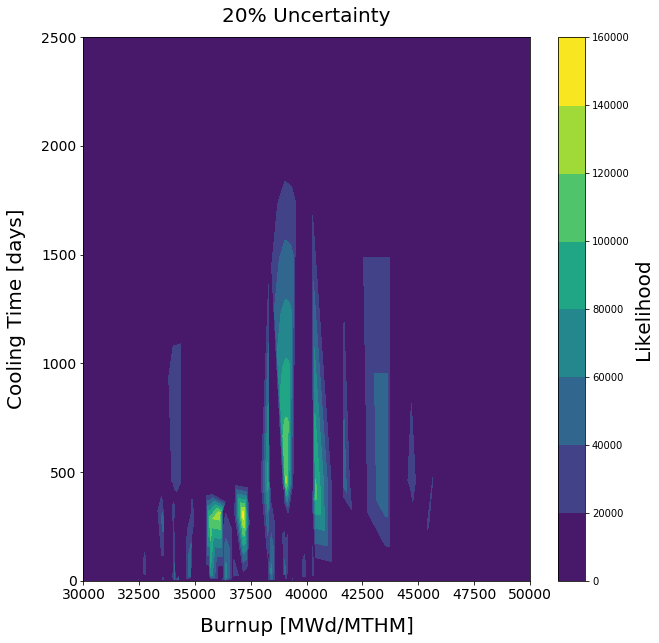

In [25]:
plt.clf()

vmin=0#meds[0]
vmax=maxs[3]

fig = plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111)#, projection='3d')
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)

z = plotXY[l4]
ax.set_title(uncss[3], fontsize=20, pad=15)

surf = ax.tricontourf(triang, z, edgecolor='none', linewidth=0, antialiased=False, norm=norm, cmap=matplotlib.cm.viridis)#, shade=True)


ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_xlim(30000, 50000)
ax.set_ylim(0, 2500)

cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('Likelihood', size=20)
ax.tick_params(labelsize=14)
plt.show()

fig.savefig('../results/19jan2020_15nuc/graphs/lsurf_ratios_0.20unc.png', bbox_inches='tight', transparent=True)

# 3. Get LL Pred Results

In [26]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [27]:
fullXY.head()

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
1,pwr,0.000839,0.53,2006.54,ce14x14,1.093932,0.004286,0.211022,0.000971,10.680506,...,4.495815e+08,0.0,-1.124658e+09,2.247908e+08,0.0,-4.998482e+08,1.498605e+08,0.0,-2.811646e+08,1.123954e+08
2,pwr,0.592485,0.53,2006.54,ce14x14,1.080899,0.004286,0.214933,0.000982,9.547601,...,4.601193e+08,0.0,-1.151023e+09,2.300597e+08,0.0,-5.115657e+08,1.533731e+08,0.0,-2.877557e+08,1.150298e+08
3,pwr,1.109213,0.53,2006.54,ce14x14,1.070205,0.004284,0.217600,0.000992,8.854379,...,4.679247e+08,0.0,-1.170551e+09,2.339623e+08,0.0,-5.202450e+08,1.559749e+08,0.0,-2.926378e+08,1.169812e+08
4,pwr,8.460400,0.53,2006.54,ce14x14,0.976211,0.004258,0.220206,0.001114,6.455085,...,5.112823e+08,0.0,-1.279030e+09,2.556411e+08,0.0,-5.684580e+08,1.704274e+08,0.0,-3.197576e+08,1.278206e+08
5,pwr,38.415629,0.53,2006.54,ce14x14,0.924535,0.004151,0.220638,0.001318,6.264409,...,5.168839e+08,0.0,-1.293052e+09,2.584419e+08,0.0,-5.746899e+08,1.722946e+08,0.0,-3.232631e+08,1.292210e+08


## Reactor Prediction

In [28]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,23.083281,3.247018,18.236497,1.901090,14.644395,1.267393,11.929467,0.950545
bwr,8.852740,7.885016,14.398986,3.942508,12.655024,2.628339,10.586944,1.971254
phwr,-68139.537089,6536.454022,-17017.232721,3268.227011,-7552.910364,2178.818007,-4241.855233,1634.113506


In [29]:
idx

{'LogLikelihood_0.05': [3915, 10917, 24787],
 'LogLikelihood_0.1': [5001, 10917, 24787],
 'LogLikelihood_0.15': [5001, 10917, 24787],
 'LogLikelihood_0.2': [5001, 10917, 24787]}

In [30]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup']])

LogLikelihood_0.05
     ReactorType    Burnup
3915         pwr  39013.38
      ReactorType    Burnup
10917         bwr  34849.93
      ReactorType    Burnup
24787        phwr  13678.58
LogLikelihood_0.1
     ReactorType    Burnup
5001         pwr  37162.09
      ReactorType    Burnup
10917         bwr  34849.93
      ReactorType    Burnup
24787        phwr  13678.58
LogLikelihood_0.15
     ReactorType    Burnup
5001         pwr  37162.09
      ReactorType    Burnup
10917         bwr  34849.93
      ReactorType    Burnup
24787        phwr  13678.58
LogLikelihood_0.2
     ReactorType    Burnup
5001         pwr  37162.09
      ReactorType    Burnup
10917         bwr  34849.93
      ReactorType    Burnup
24787        phwr  13678.58


In [31]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'CoolingTime']])

LogLikelihood_0.05
     ReactorType  CoolingTime
3915         pwr   343.237299
      ReactorType  CoolingTime
10917         bwr    24.504738
      ReactorType  CoolingTime
24787        phwr     0.000663
LogLikelihood_0.1
     ReactorType  CoolingTime
5001         pwr   306.249839
      ReactorType  CoolingTime
10917         bwr    24.504738
      ReactorType  CoolingTime
24787        phwr     0.000663
LogLikelihood_0.15
     ReactorType  CoolingTime
5001         pwr   306.249839
      ReactorType  CoolingTime
10917         bwr    24.504738
      ReactorType  CoolingTime
24787        phwr     0.000663
LogLikelihood_0.2
     ReactorType  CoolingTime
5001         pwr   306.249839
      ReactorType  CoolingTime
10917         bwr    24.504738
      ReactorType  CoolingTime
24787        phwr     0.000663
